In [1]:
# imports
import sys
import os
import mat73
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

sys.path.append( '../FIA' )
sys.path.append( '../ML' )
from FIA import *
from ML4com import *

# TensorFlow and tf.keras
import tensorflow as tf
import keras
import keras_tuner
from keras import layers, activations

In [2]:
def parse_folder(path):
    return os.listdir(path)


def mat_to_tsv(folder, file):
    """
    path: path to mat file
    saves mat files as tsv in the same folder
    """
    mat = mat73.loadmat(f"{folder}/{file}")
    for k, v in mat.items():
        if not os.path.isfile(f"{folder}/{k}.tsv"):
            df = pd.DataFrame(v)
            df.to_csv(f"{folder}/{k}.tsv", sep="\t", index=False)

In [3]:
for file in parse_folder("../../data/comm8_0"):
    if file.endswith(".mat"):
        mat_to_tsv("../../data/comm8_0", file)

In [4]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")

In [5]:
def join_df_metNames(df):
    cols = ["metNames"] + [f"MS{i+1}" for i in range(len(df.columns) - 6)]
    comb = pd.DataFrame(columns=cols)
    for pid in df["peakID"].unique():
        comb_met_name = ""
        for met_name in df.loc[df["peakID"] == pid]["MetName"]:
            comb_met_name += met_name + "\n"
        comb.loc[len(comb.index)] = [comb_met_name[:-2]] + list(df.loc[df["peakID"] == pid].iloc[0, 6:])
    comb = comb.set_index('metNames')
    return comb

In [6]:
def standard_normalization(df, axis=1):
    return df.apply(lambda line: [(x - np.mean(line)) / np.var(line) for x in line], result_type="expand", axis=axis)

In [7]:
met_raw_comb = pd.concat( [standard_normalization( join_df_metNames(met_raw_pos) ), standard_normalization( join_df_metNames(met_raw_neg) )] )

In [45]:
from sklearn.model_selection import KFold
X = met_raw_comb.transpose()
ys = comm8
cv = 6
kf = KFold(n_splits = 6, shuffle=True)

## Model

In [39]:
def build_model(hyperparameters):
    model = keras.Sequential(name="MS_community_classifier")
    if hyperparameters.Boolean("dropout_in"):
        model.add(keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())
    
    for i in range(hyperparameters.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hyperparameters.Int(f"units_{i}", min_value=32, max_value=256, step=64),
                activation=hyperparameters.Choice("activation", ["relu", "tanh"]),
            )
        )    
    if hyperparameters.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.25, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())

    model.add(layers.Dense(1,  activation=activations.sigmoid))
    
    loss_function = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction="sum_over_batch_size", name="binary_crossentropy")

    learning_rate = hyperparameters.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    return model

In [40]:
hp = keras_tuner.HyperParameters()
hp.Fixed("dropout", True)
hp.Fixed("num_layers", 1)
hp.Fixed("units_1", 64)
hp.Fixed("activation", "relu")
hp.Fixed("lr", 1e-3)
model = build_model(hp)

In [50]:
confusion_matrices = []
accuracies = []

for y in tqdm(ys.columns):
	y = ys[y]
	conf_mats = []
	acc = []
	for train_index, val_index in kf.split(X, y):
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		history = model.fit(training_data, training_labels, epochs=10000, verbose=0)

		val_loss, val_acc = model.evaluate(validation_data,  validation_labels, verbose="auto")
		acc.append(val_acc)
		prediction = model.predict(validation_data)
		prediction = [0.0 if pred[0] < 0.5 else 1.0 for pred in prediction]
		conf_mats.append(confusion_matrix(validation_labels,  prediction))
	
	accuracies.append(acc)
	confusion_matrices.append(np.sum(conf_mats, axis=0))

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/8 [02:15<?, ?it/s]


KeyboardInterrupt: 

In [46]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=np.mean(accuracies, axis=1), confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="64(0.5)x1LR0.001,10000epochs.png")

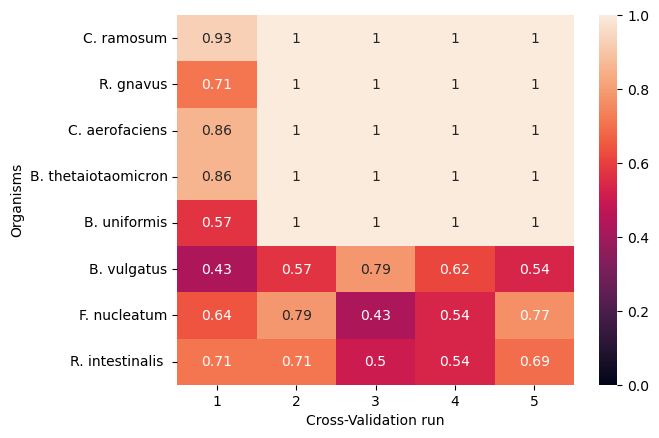

In [49]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=range(1,cv), index=strains["0"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
ax = sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)